In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure, io, color, morphology, util, filters, segmentation, transform
from sklearn.cluster import KMeans
from skimage.future import graph
from skimage import img_as_float
from scipy import ndimage as ndi

In [2]:
image = io.imread("../Графики/S2-TOC/Chen, z & Lavoie, D & Jiang, Ch & Duchesne, M & Malo, M, 2016.png")

In [52]:
image = io.imread("../Графики/PI-Tmax/Akram, R & Faqi, A & Jihad, W & Sherwani, G & Al-Ansari, N, 2021.png")

In [115]:
image = io.imread("../Графики/HI-Tmax/Barberes, G & Reis, R & Pimentel, N. & Spigolon, A.L.D. & Fonseca, P. & Karcz, P & Azevedo, M. & Barata, T, 2021.png")

In [2]:
image = io.imread("../Графики/HI-Tmax/Barberes, G & Reis, R & Pimentel, N. & Spigolon, A.L.D. & Fonseca, P. & Karcz, P & Azevedo, M. & Barata, T, 2021_upscayl_4x_realesrgan-x4plus.jpg")

In [3]:
image.shape

(4256, 3400, 3)

In [4]:
image = transform.rescale(image, 0.5, anti_aliasing=True, channel_axis=-1)

In [5]:
image.shape

(2128, 1700, 3)

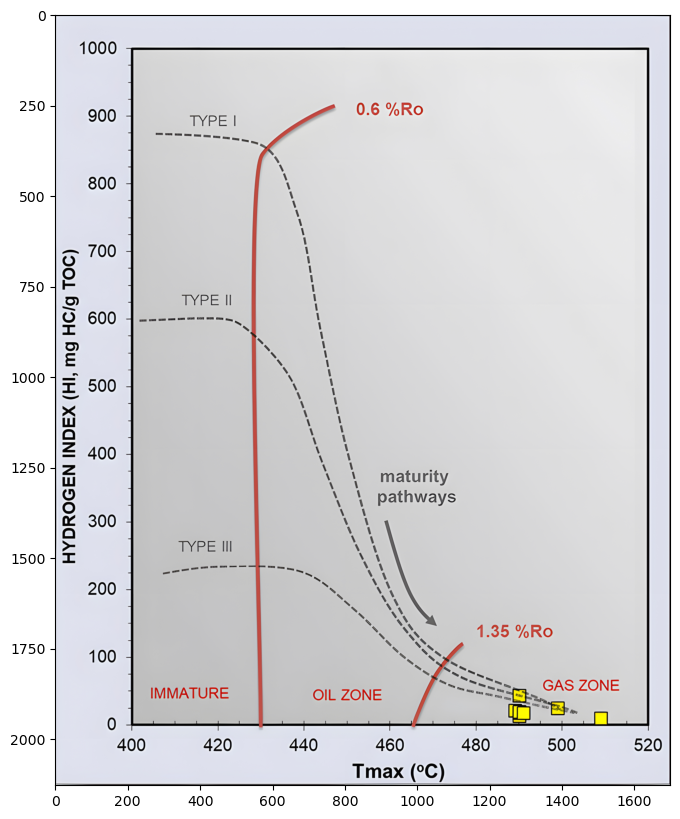

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, cmap="gray")

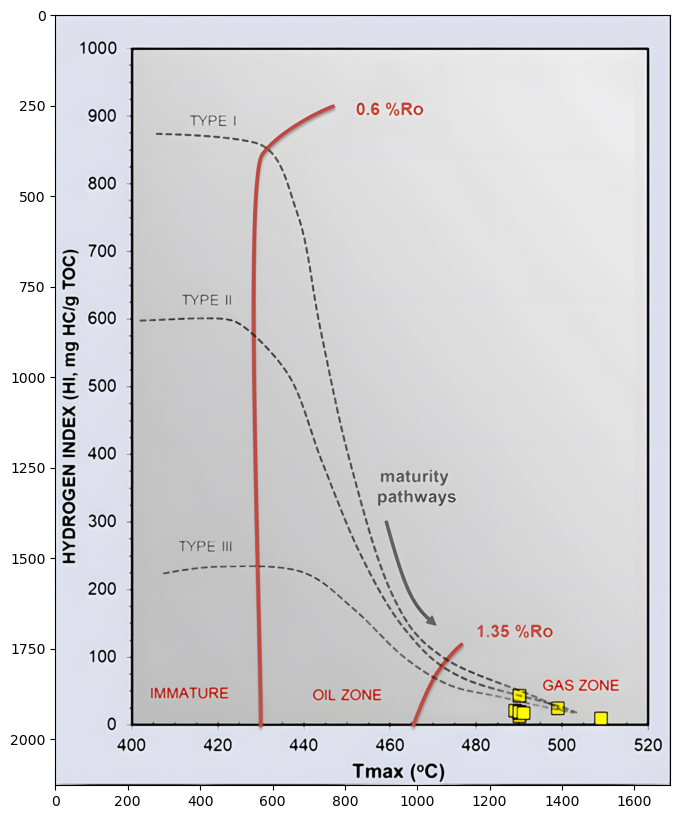

In [7]:
med_filter = filters.median(image, np.ones((5, 5, 1)))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(med_filter)

In [198]:
image = color.rgba2rgb(image)

ValueError: the input array must have size 4 along `channel_axis`, got (532, 425, 3)

In [8]:
img = color.rgb2luv(image).reshape((image.shape[1] * image.shape[0], 3))  # rgb2lab

In [9]:
kmeans = KMeans(n_clusters=7, n_init=30)
s = kmeans.fit(img)

In [10]:
kmeans.labels_

array([4, 4, 4, ..., 0, 4, 4])

In [11]:
centroid = kmeans.cluster_centers_
labels = list(kmeans.labels_)

In [12]:
len(labels)

3617600

In [13]:
percent=[]
for i in range(len(centroid)):
    j=labels.count(i)
    j=j/(len(labels))
    percent.append(j)
print(percent)

[0.34832236842105263, 0.02123562582927908, 0.009009011499336576, 0.235218929677134, 0.36934127598407784, 0.0012093653250773995, 0.01566342326404246]


([<matplotlib.patches.Wedge at 0x1bc88bdcb80>,
 [Text(0.5045482017476959, 0.97746156554269, '0'),
  Text(-0.6955068858188621, 0.8522148624487539, '1'),
  Text(-0.7732222362909903, 0.7823856934435598, '2'),
  Text(-1.0996825815118223, 0.026423851337272666, '3'),
  Text(0.32975753624955995, -1.049409342099936, '4'),
  Text(1.0942585933213012, -0.11224139585058385, '5'),
  Text(1.0986684780650084, -0.054107072609025114, '6')])

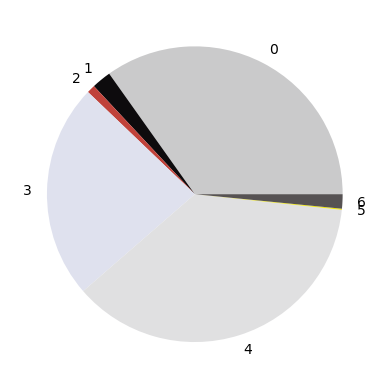

In [14]:
plt.pie(percent, colors=np.array(color.luv2rgb(centroid)), labels=np.arange(len(centroid)))

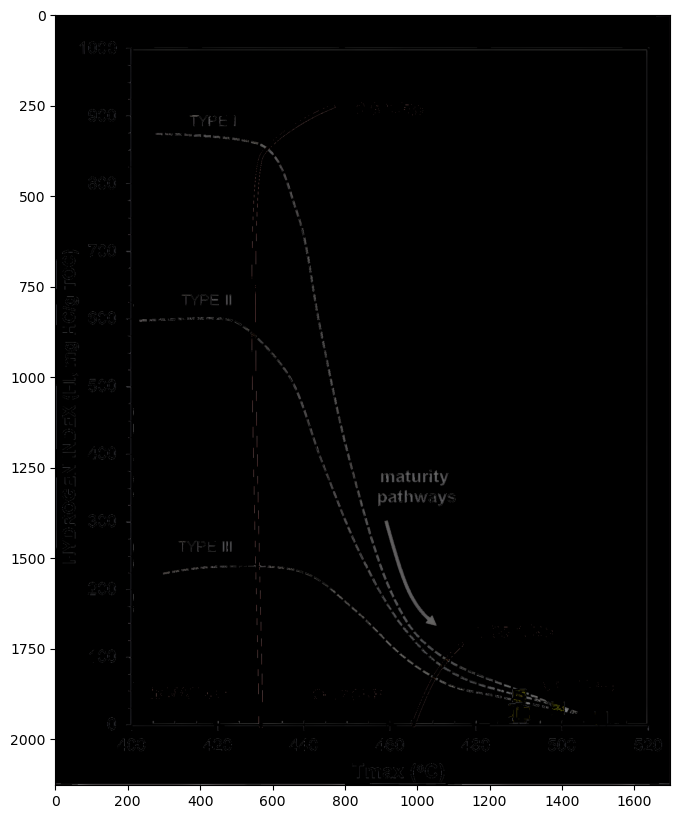

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
labels_array = np.array(labels).reshape(image.shape[0], image.shape[1])
label_bool = (labels_array == 6)
ax.imshow(image * np.repeat(label_bool[:, :, None], 3, axis=-1))

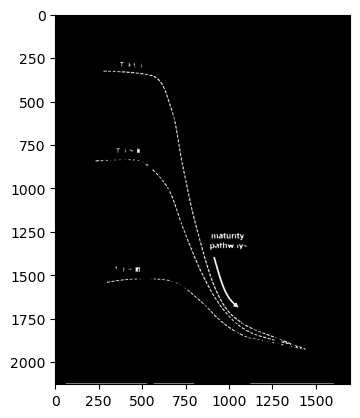

In [46]:
binary = filters.median(label_bool, np.ones((3, 3)))
binary = morphology.remove_small_objects(binary, 5)
binary = morphology.remove_small_holes(binary, 5)
binary = morphology.binary_opening(binary, morphology.disk(1))
binary = morphology.binary_closing(binary, morphology.disk(3))

# binary = morphology.convex_hull_object(binary)
plt.imshow(binary, cmap="gray")

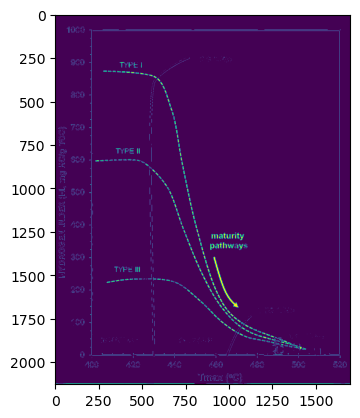

In [38]:
plt.imshow(label_bool)

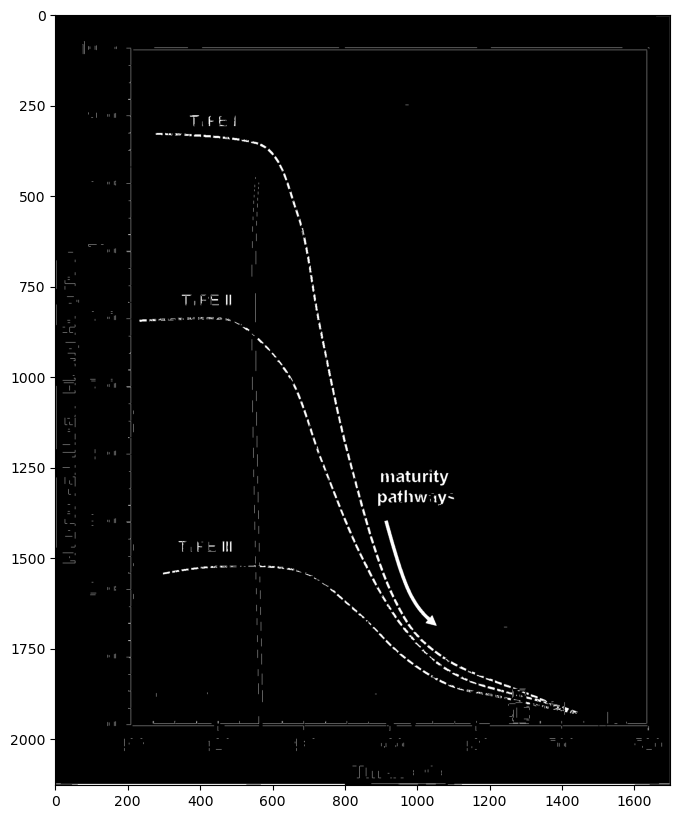

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(binary, cmap="gray")

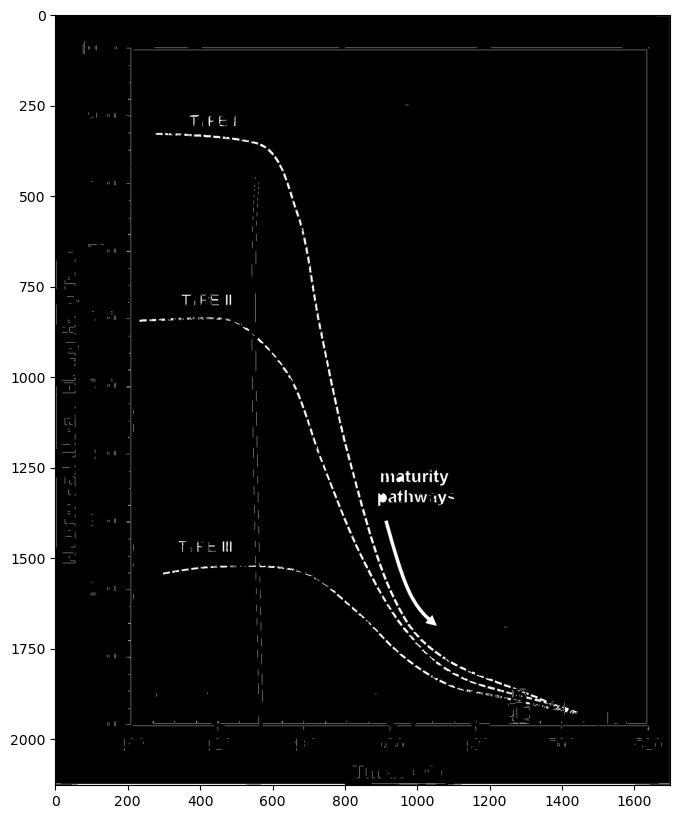

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
binary[binary < 1] = 0
ax.imshow(ndi.binary_fill_holes(binary), cmap="gray")

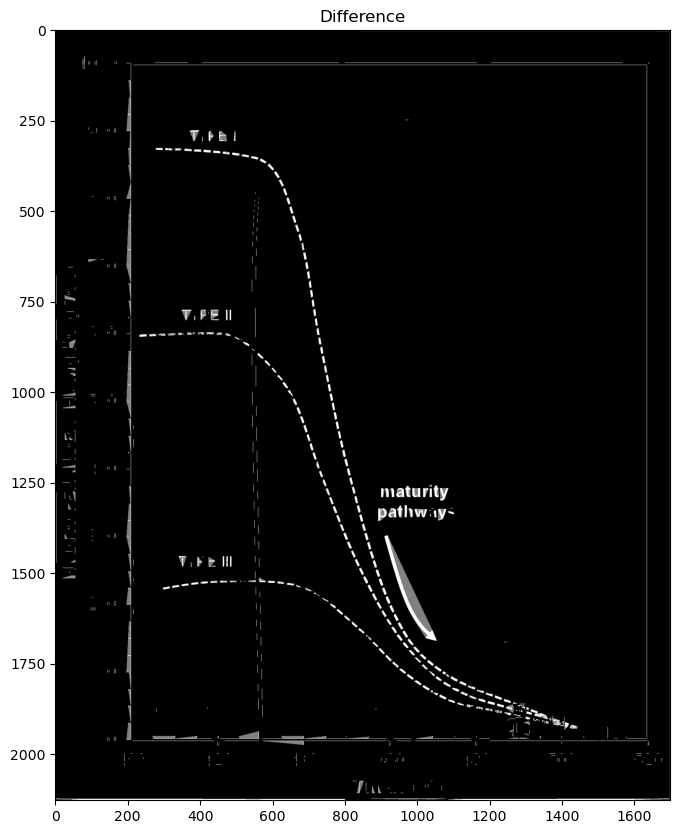

In [20]:
chull_diff = img_as_float(morphology.convex_hull_object(binary))
chull_diff[binary] = 2

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Difference')
ax.imshow(chull_diff, cmap=plt.cm.gray)

In [ ]:
chull_diff

In [21]:
points = np.concatenate(measure.find_contours(binary, 0.8))[:, ::-1]

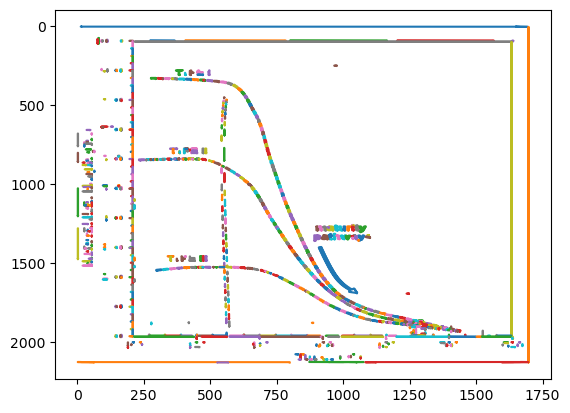

In [22]:
for c in measure.find_contours(binary, 0.5):
    plt.plot(c[:, 1], c[:, 0], '-')
plt.gca().invert_yaxis()

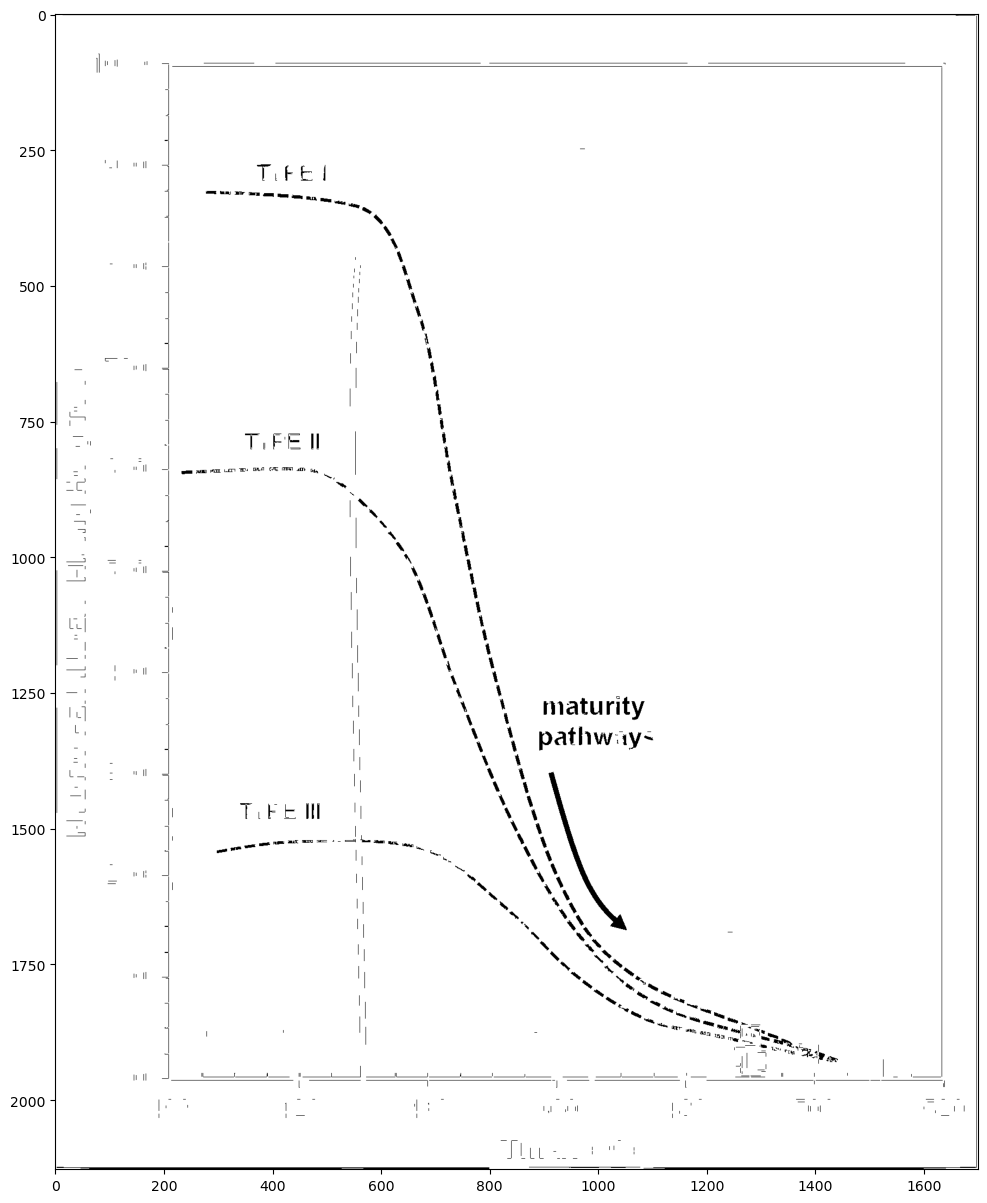

In [23]:
binary_inv = util.invert(binary)
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(binary_inv, cmap="gray")

In [83]:
angles_x = np.linspace(9*np.pi/20, 11*np.pi/20, 90, endpoint=True)
angles_y = np.linspace(-np.pi/20, np.pi/20, 90, endpoint=False)
angles_other = np.linspace(np.pi/8, 3*np.pi/8, 180, endpoint=False)
h, theta, d = transform.hough_line(binary_inv, theta=angles_x)

In [84]:
colors = plt.get_cmap("hsv")(np.linspace(0, 1, 20))
rng = np.random.default_rng()
rng.shuffle(colors)

In [85]:
def line_intersection(l1, l2):
    l1_p1, l1_p2 = l1
    l2_p1, l2_p2 = l2
    
    p = l1_p1
    r = (l1_p2-l1_p1)

    q = l2_p1
    s = (l2_p2-l2_p1)

    t = np.cross(q - p, s)/np.cross(r, s)

    return p + t*r

In [86]:
# if np.isclose(slope, 0):
#     start = vxlo, y1
#     stop = vxhi, y1
# elif np.isinf(slope):
#     start = x1, vylo
#     stop = x1, vyhi
# else:
#     _, start, stop, _ = sorted([
#         (vxlo, y1 + (vxlo - x1) * slope),
#         (vxhi, y1 + (vxhi - x1) * slope),
#         (x1 + (vylo - y1) / slope, vylo),
#         (x1 + (vyhi - y1) / slope, vyhi),
#     ])

(-0.7589236739924349, 429.99933027256805) 0
(0.035298775534538744, 19.999968849886887) 0
(-0.6865611841466446, 388.99939413029995) 0
(-0.8524654291589443, 482.99924772476834) 0
(0.0035298775534538746, 1.9999968849886887) 0


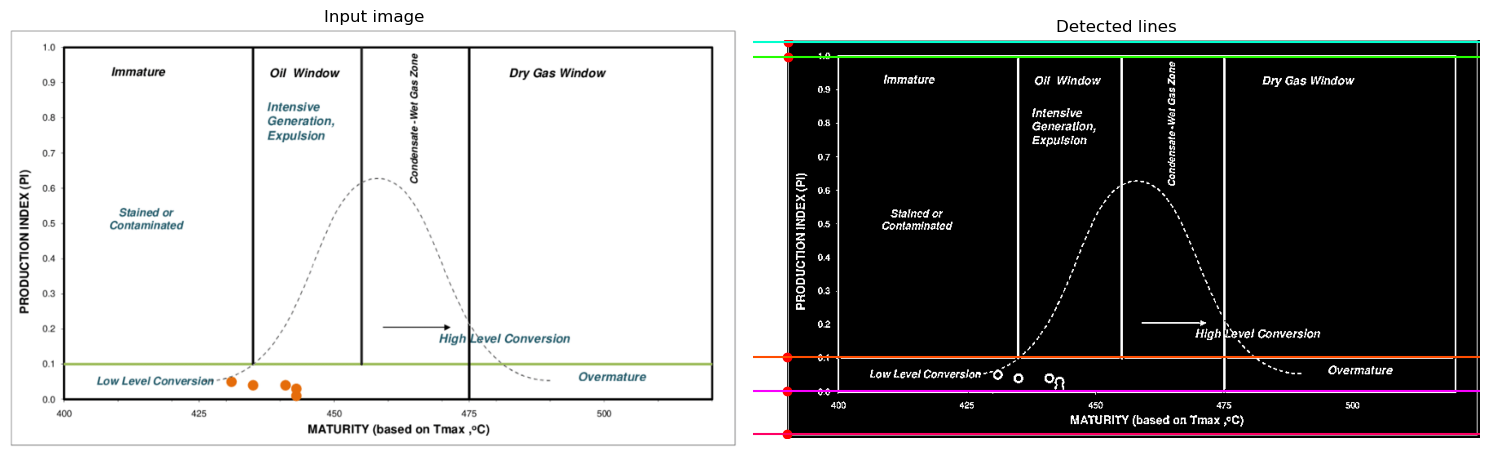

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title("Input image")
ax[0].set_axis_off()

ax[1].imshow(binary_inv, cmap="gray")
ax[1].set_ylim((binary_inv.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title("Detected lines")
x = np.linspace(0, binary_inv.shape[1], 1000, endpoint=False)

for i, (_, angle, dist) in enumerate(zip(*transform.hough_line_peaks(h, theta, d))):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[1].plot(x0, y0, "ro")
    ang = np.tan(angle + np.pi / 2)
    if np.allclose(ang, 0, atol=0.01):
        ang = 0
    ax[1].axline((x0, y0), slope=ang, color=colors[i])
    print((x0, y0), ang)

plt.tight_layout()
plt.show()

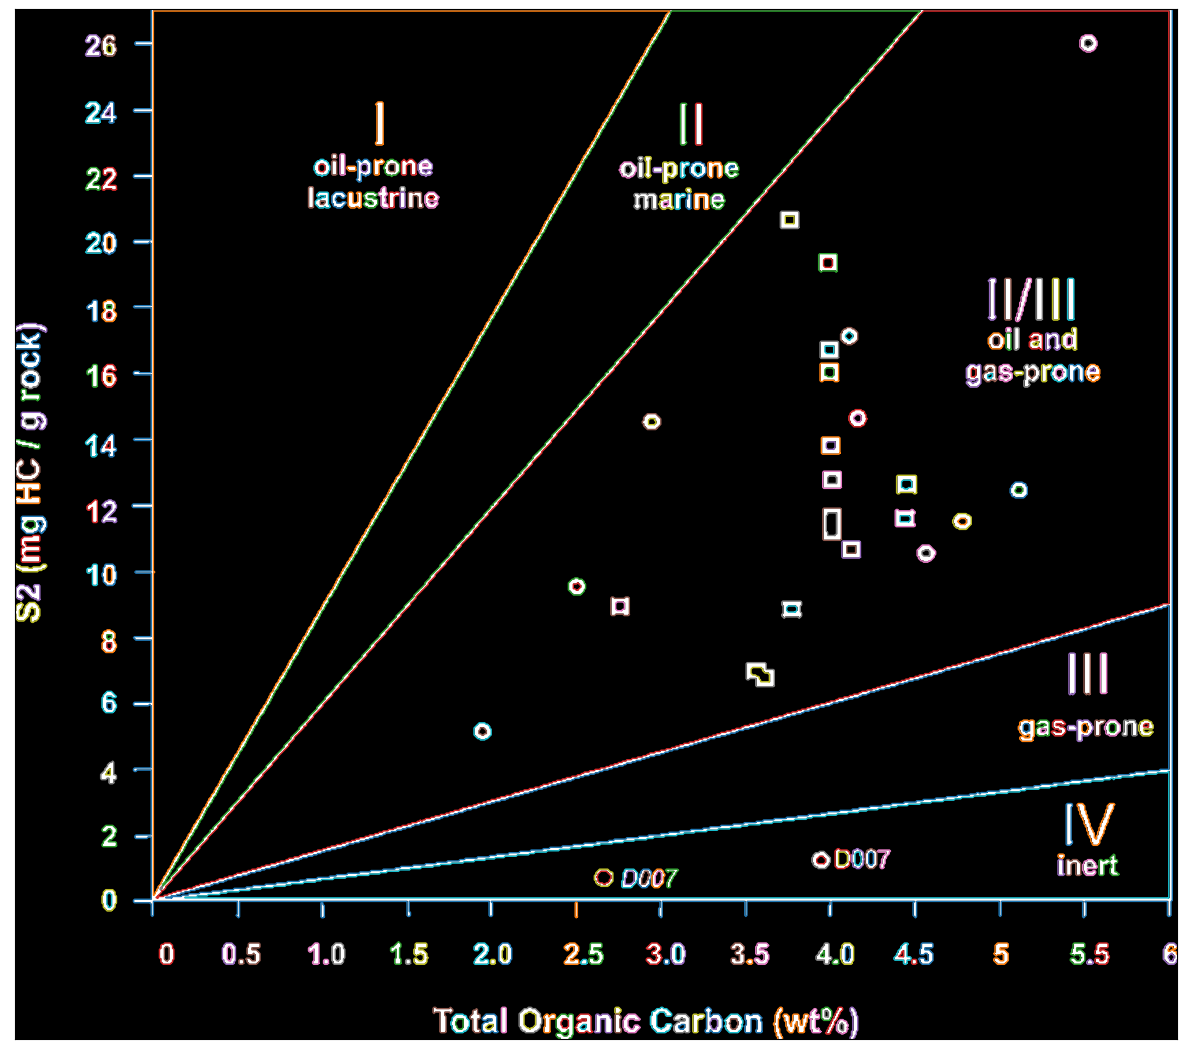

In [73]:
contours = measure.find_contours(binary, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(binary_inv, cmap="gray")

for contour in contours:
    # segmentation.flood_fill(binary_inv, (contour[0][1]-1, contour[0][0]-1), 255)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [69]:
skeleton = morphology.skeletonize(binary_inv)

In [70]:
skeleton

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

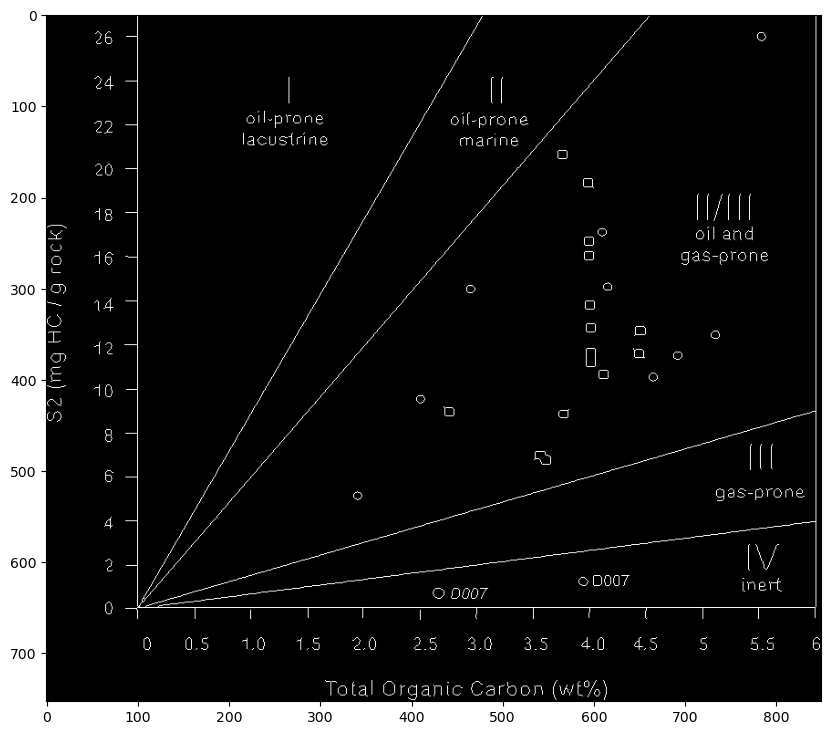

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(skeleton, cmap="gray")